#### Import libraries  

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize


from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os, PIL, re
from scipy.spatial import distance
from sklearn.utils import shuffle
from tensorflow.keras import datasets, layers, models
from tslearn.preprocessing import TimeSeriesResampler

#### Parameters  

In [2]:
#csv_in = 'cov_japan_2021_07_30.csv'

dt = 0.01  # for odeint

#### Definition of differencial equations of SEIR model  
- S: #Susceptible = the number of people who are not immune
 - 影響を受けやすい = 免疫を持たない人数  
- E: #Exposed = the number of people who are infected and during the incubation period
 - 曝露されている = 感染し、かつ潜伏期間中の人数
- I: #Infectious = the number of people who are onset
 - 伝染性のある = すでに発症している人数
- R: #Removed = the number of people who have been infected and are recovered (have immunity) or dead
 - この系から取り除かれた = 免疫を獲得した or 死亡した人数
- beta: infectious rate (S -> E, 感染率)
- lp: length of latent period (incubation period, E -> I, 潜伏期間)
- ip: length of infectious period (I -> R, 感染期間)

In [98]:
def seir_eq(v, t, beta, lp, ip):
    S, E, I, R = v
    dSdt = -beta * S * I
    dEdt = beta * S * I - E / lp
    dIdt = E / lp - I / ip
    dRdt = I / ip
    return dSdt, dEdt, dIdt, dRdt

In [99]:
def estimate_seir(seir_eq, init_state, t, beta, lp, ip, num_t, step_t):
    sol = odeint(seir_eq, init_state, t, args=(beta, lp, ip))
    est = sol[0:num_t:step_t]
    return est

## Deaths

In [48]:
df_deaths = pd.read_csv('cov_datasets/death_total.csv')
print(df_deaths.shape)
print(df_deaths.dtypes)
df_deaths

(555, 2)
日付       object
死亡者数    float64
dtype: object


,日付,死亡者数
0,2020/2/14,1.0
1,2020/2/15,1.0
2,2020/2/16,1.0
3,2020/2/17,1.0
4,2020/2/18,1.0
...,...,...
550,2021/8/17,15460.0
551,2021/8/18,15494.0
552,2021/8/19,15527.0
553,2021/8/20,15556.0


## Recovered

In [49]:
df_recovered = pd.read_csv('cov_datasets/recovery_total.csv')
df_recovered = df_recovered[16:]
print(df_recovered.shape)
print(df_recovered.dtypes)
df_recovered.head()


(555, 2)
日付               object
退院、療養解除となった者    float64
dtype: object


,日付,退院、療養解除となった者
16,2020/2/14,12.0
17,2020/2/15,12.0
18,2020/2/16,13.0
19,2020/2/17,12.0
20,2020/2/18,14.0


In [50]:
df_recovered = df_recovered.reset_index()
df_recovered = df_recovered.drop(['index','日付'], axis=1)
df_recovered

,退院、療養解除となった者
0,12.0
1,12.0
2,13.0
3,12.0
4,14.0
...,...
550,993758.0
551,1008309.0
552,1020747.0
553,1033914.0


## Infected

In [51]:
df_infected = pd.read_csv('cov_datasets/pcr_positive_daily.csv')
df_infected = df_infected[29:]
print(df_infected.shape)
print(df_infected.dtypes)
df_infected.head()

(555, 2)
日付                 object
PCR 検査陽性者数(単日)    float64
dtype: object


,日付,PCR 検査陽性者数(単日)
29,2020/2/14,5.0
30,2020/2/15,4.0
31,2020/2/16,1.0
32,2020/2/17,6.0
33,2020/2/18,8.0


In [52]:
df_infected = df_infected.reset_index()
df_infected = df_infected.drop(['index','日付'], axis=1)
df_infected

,PCR 検査陽性者数(単日)
0,5.0
1,4.0
2,1.0
3,6.0
4,8.0
...,...
550,19948.0
551,23909.0
552,25144.0
553,25858.0


### Concat

In [74]:
df_all = pd.concat([df_deaths,df_infected,df_recovered],axis=1)
df_all = df_all.rename(columns={"日付": "Date", "死亡者数": "Cummulative_Deaths", "PCR 検査陽性者数(単日)": "Infected", "退院、療養解除となった者": "Cummulative_Recovered"})
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all.head()

,Date,Cummulative_Deaths,Infected,Cummulative_Recovered
0,2020-02-14,1.0,5.0,12.0
1,2020-02-15,1.0,4.0,12.0
2,2020-02-16,1.0,1.0,13.0
3,2020-02-17,1.0,6.0,12.0
4,2020-02-18,1.0,8.0,14.0


In [126]:
df_all[480:]

,Date,Cummulative_Deaths,Infected,Cummulative_Recovered
480,2021-06-08,13739.0,1883.0,710871.0
481,2021-06-09,13837.0,2224.0,714925.0
482,2021-06-10,13903.0,2044.0,718300.0
483,2021-06-11,13972.0,1934.0,721837.0
484,2021-06-12,14028.0,1941.0,724762.0
...,...,...,...,...
550,2021-08-17,15460.0,19948.0,993758.0
551,2021-08-18,15494.0,23909.0,1008309.0
552,2021-08-19,15527.0,25144.0,1020747.0
553,2021-08-20,15556.0,25858.0,1033914.0


In [127]:
df_all.to_csv('cov_datasets/all.csv', index=None)

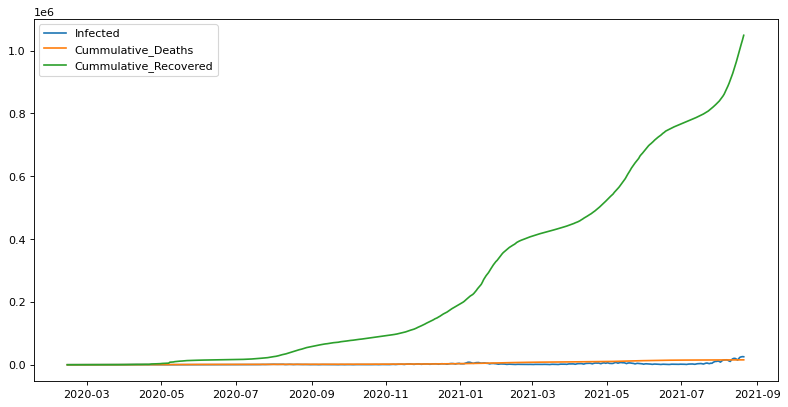

In [75]:
from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=80)
plt.plot(df_all['Date'],df_all['Infected'],label='Infected')
plt.plot(df_all['Date'],df_all['Cummulative_Deaths'],label='Cummulative_Deaths')
plt.plot(df_all['Date'],df_all['Cummulative_Recovered'],label='Cummulative_Recovered')
plt.legend()

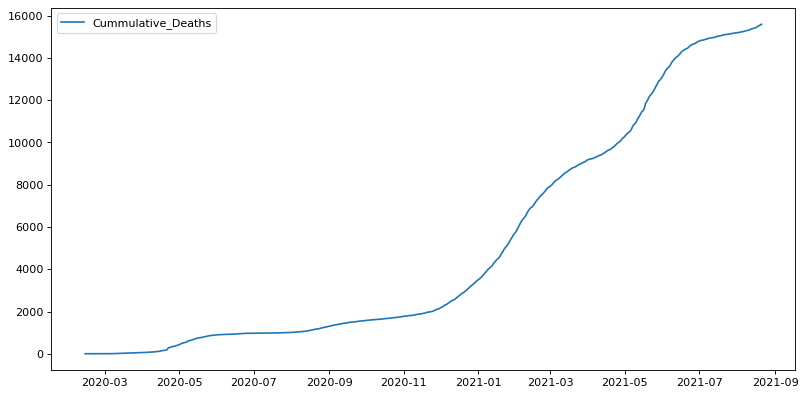

In [79]:
figure(figsize=(12, 6), dpi=80)
plt.plot(df_all['Date'],df_all['Cummulative_Deaths'],label='Cummulative_Deaths')
plt.legend()

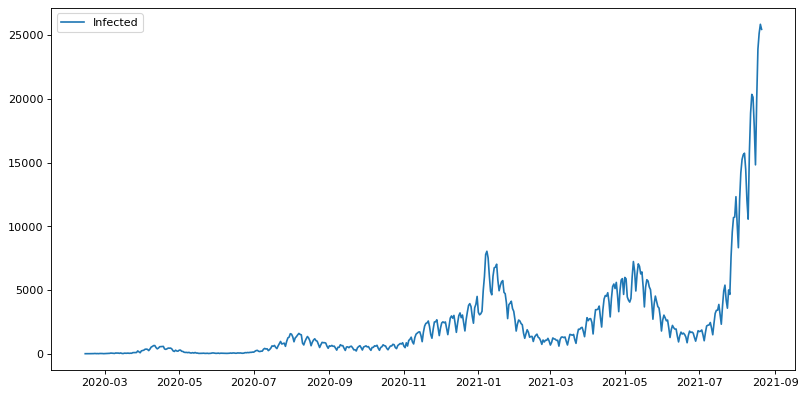

In [80]:
figure(figsize=(12, 6), dpi=80)
plt.plot(df_all['Date'],df_all['Infected'],label='Infected')
plt.legend()

In [92]:
obs_i = np.cumsum(df_all['Infected']) #observed cummulative sum of infected
obs_r = df_all['Cummulative_Deaths']+df_all['Cummulative_Recovered'] #observed cummulative sum of removed = deaths + recovered
print((obs_i+obs_r).max())


2344126.0


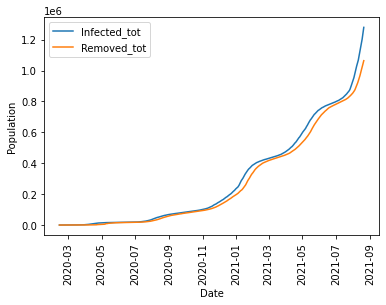

In [91]:
plt.plot(df_all['Date'], obs_i, label='Infected_tot')
plt.plot(df_all['Date'], obs_r, label='Removed_tot')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Population')
plt.legend()
plt.show()